In [115]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("data/data.pickle")
df.head()

,color_white-wine,color_yellow,color_very-pale,color_pale,color_pale-gold,color_gold,color_old-gold,color_full-gold,color_bronze,color_pale-amber,...,finish_oily,finish_salty,finish_aromatic,finish_quick,finish_long,finish_very-long,finish_lingering,coord_x,coord_y,region
name,,,,,,,,,,,,,,,,,,,,,
Aberfeldy,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.875,3.875,Highlands
Aberlour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,3.220,3.220,Highlands
Ardberg,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,6.080,6.080,Islay
Ardmore,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2.670,2.670,Highlands
Auchentoshan,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4.390,4.390,Lowlands


In [3]:
attributes_df = df.drop(columns=["coord_x", "coord_y", "region"])
attributes_df.head()

,color_white-wine,color_yellow,color_very-pale,color_pale,color_pale-gold,color_gold,color_old-gold,color_full-gold,color_bronze,color_pale-amber,...,finish_smoky,finish_sweet,finish_spicy,finish_oily,finish_salty,finish_aromatic,finish_quick,finish_long,finish_very-long,finish_lingering
name,,,,,,,,,,,,,,,,,,,,,
Aberfeldy,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Aberlour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Ardberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Ardmore,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Auchentoshan,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [62]:
def get_recommender_df(dists, ids):
    similarity_matrix = 1 - distance.squareform(dists)
    return pd.DataFrame(similarity_matrix, index=ids, columns=ids)

In [65]:
def recommend(ref, df, topn=5):
    start = 1
    end = start + topn
    return df[ref].sort_values(ascending=False).iloc[start:end].index.tolist()

## Jaccard

In [74]:
dists = distance.pdist(attributes_df.values, "jaccard")
recomender_df = get_recommender_df(dists, attributes_df.index)

In [75]:
recommend("Tobermory", df=recomender_df)

['Glen Mhor', 'Glen Elgin', 'Lochnagar', 'Oban', 'Linkwood']

# Jaccard Ponderado

In [76]:
def extract_cols_groups(columns):

    cols_groups = []

    for col in columns:
        start = col.split("_")[0]
        if start not in cols_groups:
            cols_groups.append(start)

    return cols_groups

In [85]:
def get_weighted_jaccard(df):
    dist_list = []
    
    cols_groups = extract_cols_groups(df.columns)
    for col in cols_groups:
        select_col = df.columns.str.startswith(col + "_")
        subset = df.loc(axis=1)[select_col]
        subset_dist = distance.pdist(subset, "jaccard")
        dist_list.append(subset_dist)
    
    return np.array(dist_list).mean(axis=0)

In [88]:
wg_dists = get_weighted_jaccard(attributes_df)
wg_recomender_df = get_recommender_df(wg_dists, attributes_df.index)

In [89]:
recommend("Tobermory", df=wg_recomender_df)

['Glen Elgin', 'Tomatin', 'Lochnagar', 'Linkwood', 'Glenlochy']

## Comparing Estimates

In [93]:
np.mean(np.absolute(wg_dists - dists))

0.03547646196485005

In [100]:
def pairwise_jaccard(x, y):
    intersection = x.intersection(y)
    union = x.union(y)
    return len(intersection) / len(union)

In [110]:
def compare_recomendations(topn_reco, df=recomender_df, wg_df=wg_recomender_df):
    similarities = list()
    
    col_list = df.columns
    
    for col in col_list:
        wg_recomendations_set = set(recommend(col, df=wg_recomender_df, topn=topn_reco))
        recomentations_set = set(recommend(col, df=recomender_df, topn=topn_reco))
        jaccard_sim = pairwise_jaccard(wg_recomendations_set, recomentations_set)
        similarities.append(jaccard_sim)
        
    return np.mean(similarities)

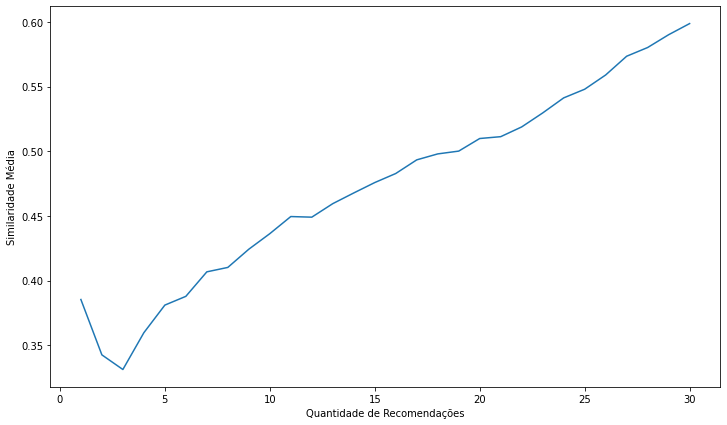

In [117]:
topn_range = range(1, 31)
similarities = [compare_recomendations(topn) for topn in topn_range]
pd.Series(similarities, index=topn_range).plot(figsize=[12, 7])
plt.ylabel("Similaridade Média")
plt.xlabel("Quantidade de Recomendações")
plt.show()

# Ranking

In [123]:
def count_recomendations(topn=5, df=wg_recomender_df):
    recomendation_list = list()
    for col in df.columns:
        recomendations = recommend(col, df=df, topn=topn)
        recomendation_list += recomendations
    whiskey, counts = np.unique(recomendation_list, return_counts=True)
    count_dict = dict(zip(whiskey, counts))
    return pd.Series(count_dict).sort_values()

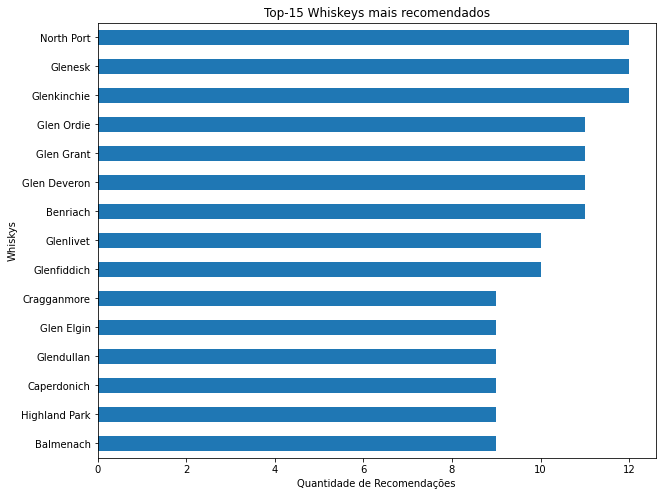

In [132]:
topn = 15
count_recomendations().tail(topn).plot(kind="barh", figsize=[10, 8])
plt.xlabel("Quantidade de Recomendações")
plt.ylabel("Whiskys")
plt.title(f"Top-{topn} Whiskeys mais recomendados")
plt.show()

# Recomendação Baseada em Atributos

In [151]:
def transform_to_attr_dict(attr_list):
    attr_dict = dict()
    for attr in attr_list:
        attr_type, propert = attr.split("_")
        if attr_type in attr_dict:
            attr_dict[attr_type].append(propert)
        else:
            attr_dict[attr_type] = [propert]
    
    return attr_dict

In [152]:
def get_attributes(whisky, df=attributes_df):
    select_attr = df.loc[whisky].values.astype("bool")
    attr_list = df.loc[whisky].index[select_attr].tolist()
    attr_dict = transform_to_attr_dict(attr_list)
    return attr_dict

get_attributes("Balmenach")

{'color': ['pale-gold'],
 'nose': ['aromatic', 'peaty', 'sweet', 'fruity', 'grassy'],
 'body': ['soft', 'medium', 'smooth', 'light'],
 'palate': ['dry', 'sweet'],
 'finish': ['long']}

In [159]:
possible_options = transform_to_attr_dict(attributes_df.columns)
print("Opções possíveis")
print()
for attr_type, prop_list in possible_options.items():
    print(attr_type + ":")
    print("; ".join(prop_list))
    print("#"*100)

Opções possíveis

color:
white-wine; yellow; very-pale; pale; pale-gold; gold; old-gold; full-gold; bronze; pale-amber; amber; full-amber; red; fino-sherry
####################################################################################################
nose:
aromatic; peaty; sweet; light; fresh; dry; fruity; grassy; salty; sherry; spicy; rich
####################################################################################################
body:
soft; medium; full; round; smooth; light; firm; oily
####################################################################################################
palate:
full; dry; sherry; big; light; smooth; clean; fruity; grassy; smoky; sweet; spicy; oily; salty; aromatic
####################################################################################################
finish:
full; dry; warm; big; light; smooth; clean; fruity; grassy; smoky; sweet; spicy; oily; salty; aromatic; quick; long; very-long; lingering
##############################

In [160]:
def get_jaccard(x, y):
    x_set = set(x)
    y_set = set(y)
    
    intersection = x_set.intersection(y_set)
    union = x_set.union(y_set)
    
    return len(intersection) / len(union)    

In [161]:
def get_pairwise_wg_jaccard(x_attr, y_attr, opts):
    jaccard_list = []
    for option in opts:
        if option in x_attr and option in y_attr:
            x = x_attr[option]
            y = y_attr[option]
            jaccard_list.append(get_jaccard(x, y))
        else:
            jaccard_list.append(0)
    return np.mean(jaccard_list)

In [171]:
def get_recomendation_on_attr(attr, topn=5, df=attributes_df, opts=possible_options):
    jaccard_list = []
    for whysky in df.index:
        y_attr = get_attributes(whysky, df=df)
        jaccard = get_pairwise_wg_jaccard(attr, y_attr, opts)
        jaccard_list.append(jaccard)
        
    return pd.Series(jaccard_list, index=df.index).sort_values(ascending=False).head(topn)

In [182]:
attr = {"color": ["white-wine"],
        "nose": ["aromatic"],
        "body": ["soft", "smooth"],
        "finish": ["long"]}

recomends = get_recomendation_on_attr(attr)
recomends

name
Glenturret      0.466667
Tomintoul       0.433333
Balmenach       0.340000
Glentauchers    0.333333
Glenfiddich     0.290000
dtype: float64

In [183]:
for whisky in recomends.index:
    print(whisky)
    print(get_attributes(whisky))
    print()

Glenturret
{'color': ['white-wine'], 'nose': ['aromatic', 'sweet'], 'body': ['soft', 'firm'], 'palate': ['big', 'smoky'], 'finish': ['fruity', 'long']}

Tomintoul
{'color': ['full-gold'], 'nose': ['aromatic', 'grassy'], 'body': ['soft', 'smooth', 'light'], 'palate': ['grassy', 'sweet'], 'finish': ['long']}

Balmenach
{'color': ['pale-gold'], 'nose': ['aromatic', 'peaty', 'sweet', 'fruity', 'grassy'], 'body': ['soft', 'medium', 'smooth', 'light'], 'palate': ['dry', 'sweet'], 'finish': ['long']}

Glentauchers
{'color': ['white-wine'], 'nose': ['sweet', 'light', 'dry', 'fruity', 'salty', 'spicy'], 'body': ['smooth', 'light'], 'palate': ['dry', 'big', 'light', 'sweet'], 'finish': ['dry', 'warm', 'long']}

Glenfiddich
{'color': ['white-wine'], 'nose': ['aromatic', 'sweet', 'light', 'fresh', 'fruity'], 'body': ['smooth', 'light', 'firm'], 'palate': ['dry', 'fruity', 'smoky', 'sweet'], 'finish': ['dry', 'smoky']}

